# Global Ocean volumetric Temperature and Salinity change

In [76]:
#Required Library
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cosima_cookbook as cc

In this script I have computed the global volume mean temperature change, same calculation valid for salinity as well.
and mathematically it is defined as  
< ${\Theta} >  = $$\int{\Theta}dv /\int(dv)$
Note;
1. To compute volume,Multiply dzt with area_t where area_t is area of the ocean and it is two dimensional where as
   dzt is a thickness of the vertical grid cell which is 4 dimensional ( including time)
2. We multipy temperature with Volume calculated above and then integrate in horizontally and vertically and the 
   resultant sum devided by horizontally and vertically avergae volume aas shown in equation above.


   

   

In [77]:
#Deafult data set reading here and can be created by own database
session = cc.database.create_session()

In [78]:
#Some basic function tom get more detilas about experiments and files
#df =cc.querying.get_experiments(session)
#cc.querying.get_experiments(session)
#pd.set.option()

In [81]:
#expt ='1deg_jra55_ryf9091_spinup1_B1'
#variable ='temp'
#pd.set_option("display.max_rows",200) # to see max number of experiments 
#df
#df.iloc[30:50]  #to check the experiment for providing an index

In [22]:
#darray =cc.querying.getvar('025deg_jra55v13_ryf8485_gmredi6','temp',session,ncfile='ocean_month.nc')

In [82]:
from dask.distributed import Client
client = Client(n_workers=4)
client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:40855 Dashboard: http://127.0.0.1:37348/status,Cluster Workers: 4 Cores: 8 Memory: 33.67 GB


In [83]:
temp =cc.querying.getvar('025deg_jra55v13_ryf8485_gmredi6','temp',session,ncfile='ocean.nc')

In [84]:
dzt =cc.querying.getvar('025deg_jra55v13_ryf8485_gmredi6','dzt',session,ncfile='ocean.nc')

In [85]:
grid  =xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_ryf8485_gmredi6/output111/ocean/ocean_grid.nc') #we should have have function which give to us a grid variable 
#grid   #Note: We should include the function which directly read the grid files because heer I need to provide explicity read the ocean_grid.nc file

In [86]:
Volume=dzt*grid.area_t #broadcasting
Volume=Volume.fillna(0) #NAN values to zeros as weighted average does not consider NaN values

In [89]:
tot_vol =Volume.isel(time=0).sum()
#tot_vol.compute()

In [93]:
Volume_mean_temp=temp.isel(time=0).weighted(Volume.isel(time=0)).mean()
#Volume_mean_temp.compute()

In [97]:
Volume_mean_temp=temp.isel(time=slice(0,20)).weighted(Volume.isel(time=slice(0,20))).mean('st_ocean').mean('xt_ocean').mean('yt_ocean')
Volume_mean_temp_deg =Volume_mean_temp-273.15 #Kelvin to Celsius
#Volume_mean_temp_deg.plot()

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/xarray/core/computation.py:1215: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/xarray/core/computation.py:1215: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])


# Global mean temperature without weighted

In [122]:
global_temp =temp.isel(time=slice(0,20)).mean('st_ocean').mean('xt_ocean').mean('yt_ocean')
global_temp_deg =global_temp-273.15 #Kelvin to Celsius

In [120]:
#global_temp.plot()

Text(0.5, 1.0, 'Global mean Temperature Change')

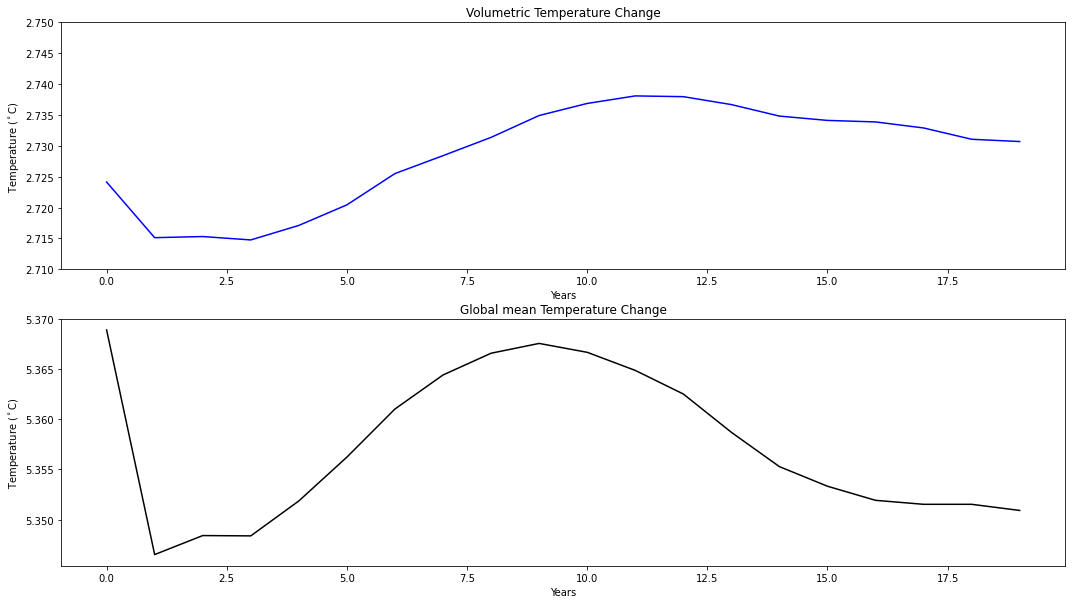

In [124]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(2, 1, 1)
ax.plot(Volume_mean_temp_deg,'b')
plt.ylim(2.71,2.75)
plt.xlabel('Years')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('Volumetric Temperature Change')

ax = fig.add_subplot(2, 1, 2)
ax.plot(global_temp_deg,'k')
#plt.ylim(2.70,2.73)
plt.xlabel('Years')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('Global mean Temperature Change')

In [ ]:
plt.savefig('Global_ocean_volume_mean_temperature.png')